# Split-and-Denoise (SnD) for Korean Text with KoGPT2

이 노트북은 SnD(Split-and-Denoise) 프레임워크를 **KoGPT2 (SKT-AI)** 모델과 한국어 텍스트에 적용하는 실험입니다.

## 참고자료
- **논문**: [Split-and-Denoise: Protect large language model inference with local differential privacy](https://arxiv.org/abs/2310.09130) (ICML 2024)
- **SnD 코드**: [https://github.com/NusIoraPrivacy/eaas-privacy](https://github.com/NusIoraPrivacy/eaas-privacy)
- **KoGPT2**: [https://github.com/SKT-AI/KoGPT2](https://github.com/SKT-AI/KoGPT2)

## 1. 환경 설정 및 라이브러리 설치

In [1]:
# 필요한 패키지 설치
!pip install torch transformers datasets tqdm numpy h5py -q

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from transformers import PreTrainedTokenizerFast, GPT2Model, GPT2LMHeadModel
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torch.distributions.gamma import Gamma
import warnings
warnings.filterwarnings('ignore')

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. 설정 및 하이퍼파라미터

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    # Model settings - KoGPT2 사용
    base_model: str = "skt/kogpt2-base-v2"  # SKT KoGPT2

    # Privacy settings
    noise_mechanism: str = "ChiDP"  # 'Gaussian' or 'ChiDP'
    train_eta: float = 100.0  # privacy budget for training
    test_eta: float = 100.0   # privacy budget for testing
    noise_std: float = 2.0    # for Gaussian noise
    clip: str = "norm"        # 'none', 'element', 'norm'

    # Training settings
    denoise_epochs: int = 2
    base_batch_size: int = 16
    denoise_batch_size: int = 16
    token_length: int = 128  # 한국어는 토큰이 길어질 수 있으므로 조정 가능
    denoise_size: int = 5000  # 데모용으로 줄임
    noise_per_sample: int = 2

    # Denoise model settings
    num_heads: int = 8
    num_layers: int = 6
    dim_head: int = 256
    d_ff: int = 1024
    dropout: float = 0.2
    att_pool: bool = True
    mask_init: bool = True
    mask_attn: bool = True
    loss: str = "mse"  # 'mse' or 'cosEmb'

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Embedding size dictionary (KoGPT2는 GPT2와 동일한 768 차원)
EMB_SIZE_DICT = {
    "skt/kogpt2-base-v2": 768,
    "gpt2": 768,
    "gpt2-medium": 1024,
    "gpt2-large": 1280,
    "gpt2-xl": 1600,
}

# Embedding norm dictionary (for clipping)
EMB_NORM_DICT = {
    "skt/kogpt2-base-v2": 7.5,
    "gpt2": 7.5,
    "gpt2-medium": 8.0,
    "gpt2-large": 8.5,
    "gpt2-xl": 9.0,
}

config = Config()
print(f"Configuration: {config}")

Configuration: Config(base_model='skt/kogpt2-base-v2', noise_mechanism='ChiDP', train_eta=100.0, test_eta=100.0, noise_std=2.0, clip='norm', denoise_epochs=2, base_batch_size=16, denoise_batch_size=16, token_length=128, denoise_size=5000, noise_per_sample=2, num_heads=8, num_layers=6, dim_head=256, d_ff=1024, dropout=0.2, att_pool=True, mask_init=True, mask_attn=True, loss='mse', device='cuda')


## 3. 노이즈 생성 함수 (Differential Privacy)

In [4]:
def sample_noise_gaussian(shape, noise_std, device):
    """Gaussian 노이즈 샘플링"""
    noise = torch.randn(shape, device=device) * noise_std
    return noise


def sample_noise_chi(shape, eta, device):
    """
    Chi-squared Differential Privacy 노이즈 샘플링
    논문의 ChiDP mechanism 구현
    """
    # Shape를 처리하여 (batch_size, seq_len, embed_dim) 형태로 조정
    if len(shape) == 3:
        batch_size, seq_len, embed_dim = shape
        flat_shape = (batch_size * seq_len * embed_dim,)
    else:
        flat_shape = shape

    # Gamma 분포로부터 샘플링 (Chi-squared의 일반화)
    alpha = torch.tensor([2.0], device=device)  # shape parameter
    beta = torch.tensor([1.0 / eta], device=device)  # rate parameter
    gamma_dist = Gamma(alpha, beta)

    # 샘플링
    noise_magnitude = gamma_dist.sample(flat_shape).squeeze(-1)

    # 방향은 uniform random
    direction = torch.randn(flat_shape, device=device)
    direction = direction / (torch.norm(direction, dim=-1, keepdim=True) + 1e-8)

    noise = noise_magnitude * direction.squeeze()

    # 원래 shape로 복원
    if len(shape) == 3:
        noise = noise.reshape(shape)

    return noise


# 테스트
test_shape = (2, 10, 768)
gaussian_noise = sample_noise_gaussian(test_shape, 2.0, device)
chi_noise = sample_noise_chi(test_shape, 100.0, device)
print(f"Gaussian noise shape: {gaussian_noise.shape}, std: {gaussian_noise.std():.4f}")
print(f"Chi noise shape: {chi_noise.shape}, std: {chi_noise.std():.4f}")

Gaussian noise shape: torch.Size([2, 10, 768]), std: 1.9852
Chi noise shape: torch.Size([2, 10, 768]), std: 1.9525


## 4. KoGPT2 모델 로드 및 유틸리티 함수

In [5]:
def load_kogpt2_model(model_name="skt/kogpt2-base-v2"):
    """KoGPT2 모델과 토크나이저 로드"""
    # KoGPT2 전용 토크나이저 (PreTrainedTokenizerFast 사용)
    tokenizer = PreTrainedTokenizerFast.from_pretrained(
        model_name,
        bos_token='</s>',
        eos_token='</s>',
        unk_token='<unk>',
        pad_token='<pad>',
        mask_token='<mask>'
    )

    # KoGPT2 모델 로드
    model = GPT2Model.from_pretrained(model_name)

    return tokenizer, model


def get_token_embedding(input_ids, model, device):
    """입력 토큰 ID로부터 토큰 임베딩 추출 (클라이언트 측)"""
    with torch.no_grad():
        embeddings = model.wte(input_ids.to(device))
    return embeddings


def get_cls_embedding(outputs, attention_mask):
    """GPT-2의 마지막 hidden state에서 CLS 임베딩 추출"""
    hidden_states = outputs.last_hidden_state

    # GPT-2는 마지막 유효 토큰의 hidden state를 사용
    sum_attention_mask = attention_mask.sum(dim=1)
    last_idx = torch.where(
        sum_attention_mask > 0,
        sum_attention_mask - 1,
        torch.zeros_like(sum_attention_mask)
    )
    last_idx = last_idx.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, hidden_states.size(2))
    cls_embs = torch.gather(hidden_states, index=last_idx, dim=1)
    cls_embs = cls_embs.squeeze(1)

    return cls_embs


# KoGPT2 모델 로드
print("Loading KoGPT2 model...")
tokenizer, base_model = load_kogpt2_model(config.base_model)
base_model = base_model.to(device)
base_model.eval()
print(f"✅ Loaded {config.base_model} model")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Embedding dimension: {EMB_SIZE_DICT[config.base_model]}")

# 토크나이저 테스트
test_text = "안녕하세요. 한국어 GPT-2 입니다.😤:)"
test_tokens = tokenizer.tokenize(test_text)
print(f"\n토크나이저 테스트:")
print(f"  입력: '{test_text}'")
print(f"  토큰: {test_tokens}")

Loading KoGPT2 model...


tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2Model LOAD REPORT from: skt/kogpt2-base-v2
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...11}.attn.bias        | UNEXPECTED |  | 
transformer.h.{0...11}.attn.masked_bias | UNEXPECTED |  | 
lm_head.weight                          | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Loaded skt/kogpt2-base-v2 model
Vocab size: 51200
Embedding dimension: 768

토크나이저 테스트:
  입력: '안녕하세요. 한국어 GPT-2 입니다.😤:)'
  토큰: ['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)']


## 5. 한국어 데이터셋 로드

In [6]:
def load_korean_dataset(dataset_name="nsmc", split="train", sample_size=5000):
    """
    한국어 데이터셋 로드
    - nsmc: 네이버 영화 리뷰 감성 분류
    - klue: KLUE 벤치마크
    - korquad: 한국어 QA
    """
    if dataset_name == "nsmc":
        # 네이버 영화 리뷰 감성 분류 데이터셋
        try:
            dataset = load_dataset("nsmc", split=split)
        except:
            # 대체 데이터셋
            dataset = load_dataset("sepidmnorozy/Korean_sentiment", split=split)
    elif dataset_name == "klue_tc":
        # KLUE Topic Classification
        dataset = load_dataset("klue", "ynat", split=split)
    elif dataset_name == "klue_nli":
        # KLUE NLI
        dataset = load_dataset("klue", "nli", split=split)
    else:
        # 기본: 한국어 위키피디아 일부
        dataset = load_dataset("wikipedia", "20220301.ko", split=split)

    # 샘플 수 제한
    if sample_size and len(dataset) > sample_size:
        indices = np.random.choice(len(dataset), sample_size, replace=False)
        dataset = dataset.select(indices)

    return dataset


# 데이터셋 로드 시도 (nsmc가 없으면 대체 데이터 생성)
try:
    korean_dataset = load_korean_dataset("nsmc", "train", sample_size=config.denoise_size)
    text_column = "document" if "document" in korean_dataset.column_names else "text"
    print(f"Loaded Korean dataset with {len(korean_dataset)} samples")
    print(f"Sample: {korean_dataset[0]}")
except Exception as e:
    print(f"Could not load Korean dataset: {e}")
    print("Creating synthetic Korean-like data for demonstration...")

    # 한국어 샘플 데이터 생성 (실제 프로젝트에서는 실제 데이터 사용)
    sample_texts = [
        "이 영화는 정말 재미있었어요. 배우들의 연기가 훌륭했습니다.",
        "오늘 날씨가 너무 좋아서 산책을 했습니다.",
        "한국어 자연어처리 연구는 매우 흥미로운 분야입니다.",
        "프라이버시 보호는 현대 AI 시스템에서 중요한 문제입니다.",
        "대형 언어 모델은 다양한 NLP 작업에 활용됩니다.",
    ] * (config.denoise_size // 5 + 1)

    sample_texts = sample_texts[:config.denoise_size]
    text_column = "text"

    class SimpleDataset:
        def __init__(self, texts):
            self.texts = texts
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            return {text_column: self.texts[idx]}

    korean_dataset = SimpleDataset(sample_texts)
    print(f"Created synthetic dataset with {len(korean_dataset)} samples")

README.md: 0.00B [00:00, ?B/s]

nsmc.py: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

dev.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1333 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2667 [00:00<?, ? examples/s]

Loaded Korean dataset with 5000 samples
Sample: {'label': 0, 'text': '애들 영화치고는 비추.. 용이 자살하려는 장면이나 실컷 고생한 난쟁이 대신 무능력한 잭이 공을 다 차지하는 이상한 영화'}


## 6. 데이터 전처리 및 Dataset 클래스

In [7]:
class KoreanTextDataset(Dataset):
    """한국어 텍스트 데이터셋"""

    def __init__(self, dataset, tokenizer, max_length=128, text_column="text"):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_column = text_column

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self.dataset, '__getitem__'):
            text = self.dataset[idx][self.text_column]
        else:
            text = self.dataset[idx]

        # 토큰화
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0)
        }


# 데이터셋 및 DataLoader 생성
train_dataset = KoreanTextDataset(
    korean_dataset,
    tokenizer,
    max_length=config.token_length,
    text_column=text_column if 'text_column' in dir() else 'text'
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.base_batch_size,
    shuffle=True,
    num_workers=0
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_dataloader)}")

# 샘플 확인
sample = next(iter(train_dataloader))
print(f"Sample input_ids shape: {sample['input_ids'].shape}")
print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")

Dataset size: 5000
Number of batches: 313
Sample input_ids shape: torch.Size([16, 128])
Sample attention_mask shape: torch.Size([16, 128])


## 7. 임베딩 추출 및 노이즈 추가 (SnD 핵심)

In [8]:
def get_embeddings_with_noise(input_ids, attention_mask, model, config, mode="train"):
    """
    SnD의 핵심 함수: 클라이언트 측에서 임베딩을 계산하고 노이즈를 추가

    Returns:
        noises: 추가된 노이즈
        clean_cls_emb: 노이즈 없는 CLS 임베딩
        noise_cls_emb: 노이즈가 추가된 CLS 임베딩
        init_emb: 초기 토큰 임베딩
    """
    device = config.device

    # 1. 토큰 임베딩 추출 (클라이언트 측)
    init_emb = get_token_embedding(input_ids, model, device)

    # 2. 노이즈 샘플링
    if config.noise_mechanism == "Gaussian":
        noise_std = config.noise_std
        noises = sample_noise_gaussian(init_emb.shape, noise_std, device)
    elif config.noise_mechanism == "ChiDP":
        eta = config.train_eta if mode == "train" else config.test_eta
        noises = sample_noise_chi(init_emb.shape, eta, device)

    # 3. 노이즈 추가
    noise_init_emb = init_emb + noises

    # 4. 클리핑 (선택적)
    if config.clip == "norm":
        max_norm = EMB_NORM_DICT.get(config.base_model, 7.5)
        all_norms = torch.norm(noise_init_emb, p=2, dim=-1)
        noise_init_emb = noise_init_emb * torch.clamp(
            max_norm / (all_norms + 1e-8), max=1
        ).unsqueeze(-1)
        noises = noise_init_emb - init_emb

    # 5. Clean embedding으로 모델 추론 (서버 측 시뮬레이션)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        clean_outputs = model(
            inputs_embeds=init_emb,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        clean_cls_emb = get_cls_embedding(clean_outputs, attention_mask)

    # 6. Noisy embedding으로 모델 추론
    with torch.no_grad():
        noise_outputs = model(
            inputs_embeds=noise_init_emb,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        noise_cls_emb = get_cls_embedding(noise_outputs, attention_mask)

    return noises, clean_cls_emb, noise_cls_emb, init_emb


# 테스트
sample_batch = next(iter(train_dataloader))
noises, clean_cls, noise_cls, init_emb = get_embeddings_with_noise(
    sample_batch['input_ids'],
    sample_batch['attention_mask'],
    base_model,
    config
)

print(f"Noise shape: {noises.shape}")
print(f"Clean CLS shape: {clean_cls.shape}")
print(f"Noisy CLS shape: {noise_cls.shape}")
print(f"Initial embedding shape: {init_emb.shape}")

# 노이즈 추가 전후 유사도 확인
cos_sim = nn.functional.cosine_similarity(clean_cls, noise_cls).mean()
print(f"\nCosine similarity before denoising: {cos_sim:.4f}")

Noise shape: torch.Size([16, 128, 768])
Clean CLS shape: torch.Size([16, 768])
Noisy CLS shape: torch.Size([16, 768])
Initial embedding shape: torch.Size([16, 128, 768])

Cosine similarity before denoising: 0.2609


## 8. Denoise 모델 정의

In [18]:
class AttentionPooling(nn.Module):
    """Attention-based pooling layer"""

    def __init__(self, d_model, d_out, dropout=0.1):
        super().__init__()
        self.attention = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.output_proj = nn.Linear(d_model, d_out)

    def forward(self, x, mask=None):
        # x: (batch, seq_len, d_model)
        attn_weights = self.attention(x).squeeze(-1)  # (batch, seq_len)

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, float('-inf'))

        attn_weights = torch.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Weighted sum
        pooled = torch.bmm(attn_weights.unsqueeze(1), x).squeeze(1)
        output = self.output_proj(pooled)

        return output


class TransformerBlock(nn.Module):
    """Transformer encoder block"""

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # Self-attention
        if mask is not None:
            # Convert to attention mask format
            key_padding_mask = (mask == 0)
        else:
            key_padding_mask = None

        attn_out, _ = self.attention(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + attn_out)

        # Feed-forward
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x


class DenoiseModel(nn.Module):
    """
    SnD Denoise 모델
    초기 임베딩, 노이즈, 노이즈가 추가된 출력을 받아서 denoised CLS 임베딩을 출력
    """

    def __init__(self, d_model, d_out, config):
        super().__init__()
        self.d_model = d_model
        self.d_out = d_out
        self.config = config

        # 입력 결합 레이어
        self.input_proj = nn.Linear(2 * d_model, d_model)
        self.activation = nn.Tanh()

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(
                d_model=d_model,
                num_heads=config.num_heads,
                d_ff=config.d_ff,
                dropout=config.dropout
            )
            for _ in range(config.num_layers)
        ])

        # Attention pooling for output
        if config.att_pool:
            self.pooling = AttentionPooling(d_model, d_out, config.dropout)
        else:
            self.pooling = nn.Linear(d_model, d_out)

        # Output projection
        self.output_proj = nn.Linear(2 * d_out, d_out)

    def forward(self, init_embedding, noise, output_cls, attention_mask=None):
        """
        Args:
            init_embedding: (batch, seq_len, d_model) - 초기 토큰 임베딩
            noise: (batch, seq_len, d_model) - 추가된 노이즈
            output_cls: (batch, d_model) - 노이즈 추가 후 CLS 임베딩
            attention_mask: (batch, seq_len) - 어텐션 마스크

        Returns:
            denoised_cls: (batch, d_out) - Denoised CLS 임베딩
        """
        batch_size = init_embedding.size(0)

        # 1. 임베딩과 노이즈 결합
        combined = torch.cat([init_embedding, noise], dim=-1)
        x = self.input_proj(combined)
        x = self.activation(x)

        # 마스킹 적용
        if self.config.mask_init and attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).expand_as(x)
            x = x.masked_fill(mask == 0, 0)

        # 2. output_cls를 시퀀스 앞에 추가
        output_cls_expanded = output_cls.unsqueeze(1)  # (batch, 1, d_model)
        x = torch.cat([output_cls_expanded, x], dim=1)  # (batch, seq_len+1, d_model)

        # Attention mask 조정
        if attention_mask is not None:
            ones = torch.ones(batch_size, 1, device=attention_mask.device)
            extended_mask = torch.cat([ones, attention_mask], dim=1)
        else:
            extended_mask = None

        # 3. Transformer layers
        for layer in self.transformer_layers:
            x = layer(x, mask=extended_mask)

        # 4. Pooling (첫 번째 토큰 사용)
        if self.config.att_pool:
            pooled = self.pooling(x, extended_mask)
        else:
            pooled = self.pooling(x[:, 0, :])  # 첫 번째 토큰만 사용

        # 5. Output projection
        final_output = torch.cat([pooled, output_cls], dim=-1)
        denoised_cls = self.output_proj(final_output)

        return denoised_cls


# Denoise 모델 초기화
embed_dim = EMB_SIZE_DICT[config.base_model]
denoise_model = DenoiseModel(d_model=embed_dim, d_out=embed_dim, config=config)
denoise_model = denoise_model.to(device)

# 파라미터 수 확인
num_params = sum(p.numel() for p in denoise_model.parameters() if p.requires_grad)
print(f"Denoise model parameters: {num_params:,}")

# model summery
print(f"Denoise model summary:")
print(denoise_model)

Denoise model parameters: 26,592,769
Denoise model summary:
DenoiseModel(
  (input_proj): Linear(in_features=1536, out_features=768, bias=True)
  (activation): Tanh()
  (transformer_layers): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1024, out_features=768, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (pooling): AttentionPooling(
    (attention): Linear(in_features=768, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output_proj): Linear(in_features

## 9. Denoise 모델 학습

In [10]:
def train_denoise_model(denoise_model, base_model, train_dataloader, config, num_epochs=2):
    """
    Denoise 모델 학습
    """
    optimizer = torch.optim.Adam(denoise_model.parameters(), lr=1e-4)

    if config.loss == 'mse':
        loss_fn = nn.MSELoss()
    elif config.loss == 'cosEmb':
        loss_fn = nn.CosineEmbeddingLoss()

    base_model.eval()
    denoise_model.train()

    training_losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, batch in enumerate(pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 여러 번 노이즈 샘플링
            for _ in range(config.noise_per_sample):
                # 임베딩 및 노이즈 추출
                noises, clean_cls_emb, noise_cls_emb, init_emb = get_embeddings_with_noise(
                    input_ids, attention_mask, base_model, config, mode="train"
                )

                # 마스킹 적용
                if config.mask_init:
                    mask = attention_mask.unsqueeze(-1).expand_as(noises)
                    noises = noises.masked_fill(mask == 0, 0)
                    init_emb = init_emb.masked_fill(mask == 0, 0)

                # Denoise 모델 forward
                if config.mask_attn:
                    y_pred = denoise_model(init_emb, noises, noise_cls_emb, attention_mask)
                else:
                    y_pred = denoise_model(init_emb, noises, noise_cls_emb)

                # Loss 계산
                if config.loss == 'mse':
                    loss = loss_fn(y_pred, clean_cls_emb)
                elif config.loss == 'cosEmb':
                    target = torch.ones(y_pred.size(0)).to(device)
                    loss = loss_fn(y_pred, clean_cls_emb, target)

                # Backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())

            pbar.set_postfix({'loss': np.mean(epoch_losses[-10:])})

        avg_loss = np.mean(epoch_losses)
        training_losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")

    return training_losses


# 학습 실행 (데모용으로 epoch 수 줄임)
print("Starting denoise model training...")
training_losses = train_denoise_model(
    denoise_model,
    base_model,
    train_dataloader,
    config,
    num_epochs=config.denoise_epochs
)
print("Training completed!")

Starting denoise model training...


Epoch 1/2: 100%|██████████| 313/313 [03:54<00:00,  1.33it/s, loss=1.51]


Epoch 1 - Average Loss: 1.502102


Epoch 2/2: 100%|██████████| 313/313 [03:57<00:00,  1.32it/s, loss=1.43]

Epoch 2 - Average Loss: 1.357616
Training completed!


## 10. Denoise 성능 평가

In [11]:
def evaluate_denoise(denoise_model, base_model, dataloader, config):
    """
    Denoise 모델 평가
    """
    denoise_model.eval()
    base_model.eval()

    mse_before_list = []
    mse_after_list = []
    cos_before_list = []
    cos_after_list = []

    cosine_similarity = nn.functional.cosine_similarity
    mse_metric = nn.MSELoss(reduction='none')

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 임베딩 및 노이즈 추출
            noises, clean_cls_emb, noise_cls_emb, init_emb = get_embeddings_with_noise(
                input_ids, attention_mask, base_model, config, mode="test"
            )

            # 마스킹 적용
            if config.mask_init:
                mask = attention_mask.unsqueeze(-1).expand_as(noises)
                noises = noises.masked_fill(mask == 0, 0)
                init_emb = init_emb.masked_fill(mask == 0, 0)

            # Denoise
            if config.mask_attn:
                denoised_cls_emb = denoise_model(init_emb, noises, noise_cls_emb, attention_mask)
            else:
                denoised_cls_emb = denoise_model(init_emb, noises, noise_cls_emb)

            # MSE 계산
            mse_before = mse_metric(clean_cls_emb, noise_cls_emb).mean(dim=-1)
            mse_after = mse_metric(clean_cls_emb, denoised_cls_emb).mean(dim=-1)

            # Cosine similarity 계산
            cos_before = cosine_similarity(clean_cls_emb, noise_cls_emb)
            cos_after = cosine_similarity(clean_cls_emb, denoised_cls_emb)

            mse_before_list.extend(mse_before.cpu().numpy())
            mse_after_list.extend(mse_after.cpu().numpy())
            cos_before_list.extend(cos_before.cpu().numpy())
            cos_after_list.extend(cos_after.cpu().numpy())

    results = {
        'mse_before': np.mean(mse_before_list),
        'mse_after': np.mean(mse_after_list),
        'cos_before': np.mean(cos_before_list),
        'cos_after': np.mean(cos_after_list),
        'mse_improvement': (np.mean(mse_before_list) - np.mean(mse_after_list)) / np.mean(mse_before_list) * 100,
        'cos_improvement': (np.mean(cos_after_list) - np.mean(cos_before_list)) / (1 - np.mean(cos_before_list)) * 100
    }

    return results


# 평가 실행
print("\nEvaluating denoise model...")
eval_results = evaluate_denoise(denoise_model, base_model, train_dataloader, config)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Privacy Budget (η): {config.test_eta}")
print(f"Noise Mechanism: {config.noise_mechanism}")
print("-"*60)
print(f"MSE (before denoise): {eval_results['mse_before']:.6f}")
print(f"MSE (after denoise):  {eval_results['mse_after']:.6f}")
print(f"MSE Improvement: {eval_results['mse_improvement']:.2f}%")
print("-"*60)
print(f"Cosine Similarity (before): {eval_results['cos_before']:.4f}")
print(f"Cosine Similarity (after):  {eval_results['cos_after']:.4f}")
print(f"Cosine Improvement: {eval_results['cos_improvement']:.2f}%")
print("="*60)


Evaluating denoise model...


Evaluating: 100%|██████████| 313/313 [01:34<00:00,  3.32it/s]


EVALUATION RESULTS
Privacy Budget (η): 100.0
Noise Mechanism: ChiDP
------------------------------------------------------------
MSE (before denoise): 4.056487
MSE (after denoise):  1.336053
MSE Improvement: 67.06%
------------------------------------------------------------
Cosine Similarity (before): 0.2642
Cosine Similarity (after):  0.7026
Cosine Improvement: 59.58%


## 11. 다양한 Privacy Budget에서 실험

In [12]:
def experiment_with_different_etas(denoise_model, base_model, dataloader, config, etas=[50, 100, 150]):
    """
    다양한 privacy budget에서 실험
    """
    all_results = []

    for eta in etas:
        print(f"\nTesting with η = {eta}")

        # Config 업데이트
        test_config = Config()
        test_config.test_eta = eta
        test_config.noise_mechanism = config.noise_mechanism
        test_config.clip = config.clip
        test_config.mask_init = config.mask_init
        test_config.mask_attn = config.mask_attn
        test_config.att_pool = config.att_pool

        results = evaluate_denoise(denoise_model, base_model, dataloader, test_config)
        results['eta'] = eta
        all_results.append(results)

        print(f"  Cosine (before/after): {results['cos_before']:.4f} → {results['cos_after']:.4f}")
        print(f"  MSE (before/after): {results['mse_before']:.4f} → {results['mse_after']:.4f}")

    return all_results


# 다양한 η 값으로 실험
print("\n" + "="*60)
print("EXPERIMENTS WITH DIFFERENT PRIVACY BUDGETS")
print("="*60)

etas_to_test = [50, 100, 200]
all_results = experiment_with_different_etas(
    denoise_model, base_model, train_dataloader, config, etas=etas_to_test
)


EXPERIMENTS WITH DIFFERENT PRIVACY BUDGETS

Testing with η = 50


Evaluating: 100%|██████████| 313/313 [01:34<00:00,  3.31it/s]


  Cosine (before/after): 0.4860 → 0.7414
  MSE (before/after): 2.6305 → 1.1799

Testing with η = 100


Evaluating: 100%|██████████| 313/313 [01:33<00:00,  3.33it/s]


  Cosine (before/after): 0.2655 → 0.7036
  MSE (before/after): 4.0337 → 1.3326

Testing with η = 200


Evaluating: 100%|██████████| 313/313 [01:33<00:00,  3.34it/s]

  Cosine (before/after): 0.1920 → 0.6790
  MSE (before/after): 4.7058 → 1.4235


## 12. 결과 시각화

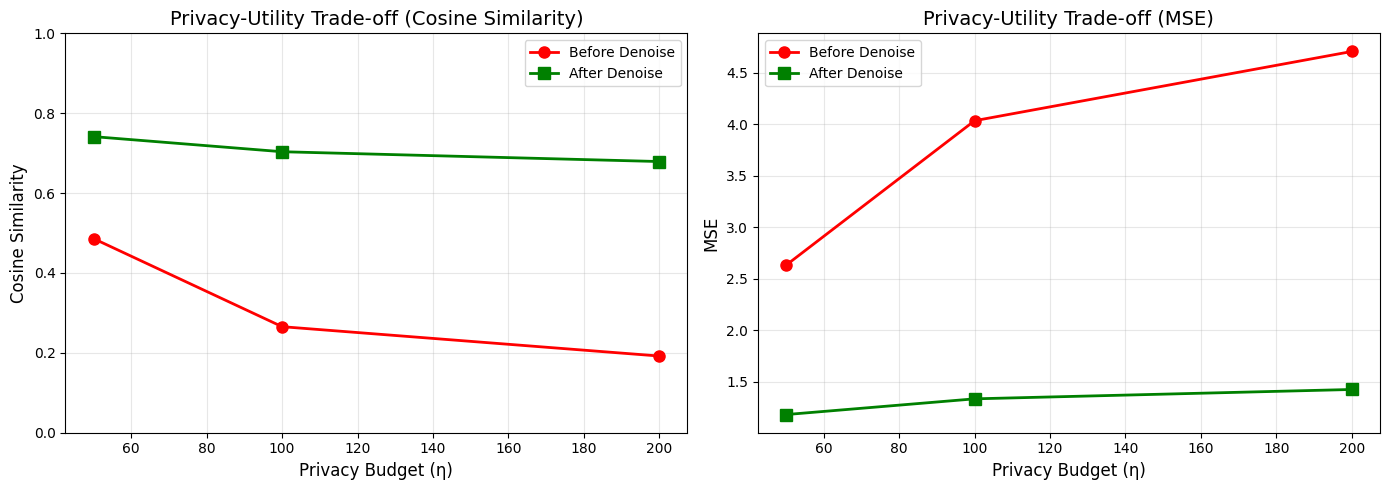


Plot saved as 'privacy_utility_tradeoff.png'


In [13]:
import matplotlib.pyplot as plt

# 결과 시각화
if all_results:
    etas = [r['eta'] for r in all_results]
    cos_before = [r['cos_before'] for r in all_results]
    cos_after = [r['cos_after'] for r in all_results]
    mse_before = [r['mse_before'] for r in all_results]
    mse_after = [r['mse_after'] for r in all_results]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cosine Similarity
    axes[0].plot(etas, cos_before, 'o-', label='Before Denoise', color='red', linewidth=2, markersize=8)
    axes[0].plot(etas, cos_after, 's-', label='After Denoise', color='green', linewidth=2, markersize=8)
    axes[0].set_xlabel('Privacy Budget (η)', fontsize=12)
    axes[0].set_ylabel('Cosine Similarity', fontsize=12)
    axes[0].set_title('Privacy-Utility Trade-off (Cosine Similarity)', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])

    # MSE
    axes[1].plot(etas, mse_before, 'o-', label='Before Denoise', color='red', linewidth=2, markersize=8)
    axes[1].plot(etas, mse_after, 's-', label='After Denoise', color='green', linewidth=2, markersize=8)
    axes[1].set_xlabel('Privacy Budget (η)', fontsize=12)
    axes[1].set_ylabel('MSE', fontsize=12)
    axes[1].set_title('Privacy-Utility Trade-off (MSE)', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('privacy_utility_tradeoff.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nPlot saved as 'privacy_utility_tradeoff.png'")

## 13. 결과 요약

In [14]:
import pandas as pd

# 결과 테이블 생성
if all_results:
    df = pd.DataFrame(all_results)
    df = df[['eta', 'cos_before', 'cos_after', 'cos_improvement', 'mse_before', 'mse_after', 'mse_improvement']]
    df.columns = ['η', 'Cos(Before)', 'Cos(After)', 'Cos Improvement(%)', 'MSE(Before)', 'MSE(After)', 'MSE Improvement(%)']

    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

    # CSV로 저장
    df.to_csv('experiment_results.csv', index=False)
    print("\nResults saved to 'experiment_results.csv'")


SUMMARY TABLE
  η  Cos(Before)  Cos(After)  Cos Improvement(%)  MSE(Before)  MSE(After)  MSE Improvement(%)
 50     0.486021    0.741382           49.683140     2.630495    1.179877           55.146198
100     0.265520    0.703560           59.639465     4.033738    1.332637           66.962730
200     0.192036    0.679003           60.270870     4.705848    1.423544           69.749474

Results saved to 'experiment_results.csv'


## 14. 모델 저장

In [15]:
import os

# 모델 저장 디렉토리 생성
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# Denoise 모델 저장
model_path = os.path.join(save_dir, f"denoise_model_{config.base_model.replace('/', '_')}_eta{config.train_eta}.pt")
torch.save({
    'model_state_dict': denoise_model.state_dict(),
    'config': config.__dict__,
    'training_losses': training_losses,
}, model_path)

print(f"Model saved to: {model_path}")

Model saved to: ./saved_models/denoise_model_skt_kogpt2-base-v2_eta100.0.pt


In [16]:
print("\n" + "="*60)
print("실험 완료!")
print("="*60)
print(f"Base Model: {config.base_model}")
print(f"Noise Mechanism: {config.noise_mechanism}")
print(f"Training Privacy Budget (η): {config.train_eta}")
print(f"Number of Training Epochs: {config.denoise_epochs}")
print(f"Dataset Size: {len(train_dataset)}")
print("="*60)


실험 완료!
Base Model: skt/kogpt2-base-v2
Noise Mechanism: ChiDP
Training Privacy Budget (η): 100.0
Number of Training Epochs: 2
Dataset Size: 5000


## 16. 노이즈 추가 전/후 생성 비교 (KoGPT2)

In [17]:
from difflib import SequenceMatcher

def compare_clean_vs_noisy_generation(base_model, denoise_model, tokenizer, config, num_examples=4, max_new_tokens=100):
    """
    노이즈 추가 전/후 생성 결과 비교 (KoGPT2)
    - Clean 임베딩으로 생성 (노이즈 없음)
    - Noisy 임베딩으로 생성 (노이즈 추가)
    """
    # KoGPT2 LMHeadModel 로드 (텍스트 생성용)
    lm_model = GPT2LMHeadModel.from_pretrained(config.base_model).to(device)
    lm_model.eval()

    # 한국어 예시 텍스트 (KoGPT2에 최적화)
    sample_texts = [
        "이 영화는 정말 감동적이었어요.",
        "오늘 날씨가 너무 좋아서",
        "인공지능 기술은 우리 삶을",
        "한국의 전통 음식 중에서",
    ]

    print("=" * 90)
    print("🔬 노이즈 추가 전/후 텍스트 생성 비교 (KoGPT2)")
    print("=" * 90)
    print(f"📌 모델: {config.base_model}")
    print(f"📌 노이즈 메커니즘: {config.noise_mechanism}")
    print(f"📌 Privacy Budget (η): {config.test_eta}")
    print(f"📌 생성 토큰 수: {max_new_tokens}")
    print("=" * 90)

    all_comparisons = []

    for i, text in enumerate(sample_texts[:num_examples]):
        print(f"\n{'━' * 90}")
        print(f"📝 예시 {i+1}")
        print(f"{'━' * 90}")

        # 1. 입력 텍스트
        print(f"\n🔹 [입력] 원본 프롬프트:")
        print(f"   \"{text}\"")

        # 2. 토큰화
        encoded = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=50
        )
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        num_input_tokens = attention_mask.sum().item()
        tokens = tokenizer.tokenize(text)
        print(f"\n🔹 [토큰화] 입력 토큰 수: {num_input_tokens}")
        print(f"   토큰: {tokens}")

        # 3. 초기 임베딩 추출
        with torch.no_grad():
            init_emb = lm_model.transformer.wte(input_ids)

        # 4. 노이즈 샘플링
        if config.noise_mechanism == "ChiDP":
            noises = sample_noise_chi(init_emb.shape, config.test_eta, device)
        else:
            noises = sample_noise_gaussian(init_emb.shape, config.noise_std, device)

        # 5. 노이즈 추가 및 클리핑
        noise_init_emb = init_emb + noises

        if config.clip == "norm":
            max_norm = EMB_NORM_DICT.get(config.base_model, 7.5)
            all_norms = torch.norm(noise_init_emb, p=2, dim=-1)
            noise_init_emb = noise_init_emb * torch.clamp(
                max_norm / (all_norms + 1e-8), max=1
            ).unsqueeze(-1)
            noises = noise_init_emb - init_emb

        # 노이즈 통계
        noise_mean = noises.mean().item()
        noise_std_val = noises.std().item()
        noise_norm = torch.norm(noises).item()

        print(f"\n🔹 [노이즈 정보]")
        print(f"   평균: {noise_mean:.6f}")
        print(f"   표준편차: {noise_std_val:.6f}")
        print(f"   L2 Norm: {noise_norm:.4f}")

        # ═══════════════════════════════════════════════════════════════
        # 6. Clean 임베딩으로 텍스트 생성 (노이즈 없음)
        # ═══════════════════════════════════════════════════════════════
        print(f"\n{'─' * 90}")
        print(f"🟢 [노이즈 없음] Clean 임베딩으로 {max_new_tokens} 토큰 생성")
        print(f"{'─' * 90}")

        with torch.no_grad():
            # Clean embedding으로 forward pass
            clean_outputs = lm_model(inputs_embeds=init_emb, attention_mask=attention_mask)
            clean_logits = clean_outputs.logits[:, -1, :]
            clean_first_token = torch.argmax(clean_logits, dim=-1)

            # 생성 시작
            clean_generated_ids = torch.cat([input_ids, clean_first_token.unsqueeze(-1)], dim=-1)
            clean_generated = lm_model.generate(
                clean_generated_ids,
                max_new_tokens=max_new_tokens - 1,
                repetition_penalty=2.0,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
                use_cache=True
            )

        clean_full_text = tokenizer.decode(clean_generated[0], skip_special_tokens=True)
        clean_generated_text = clean_full_text[len(text):].strip() if len(clean_full_text) > len(text) else clean_full_text

        print(f"   생성된 텍스트:")
        print(f"   \"{clean_generated_text[:400]}{'...' if len(clean_generated_text) > 400 else ''}\"")

        # ═══════════════════════════════════════════════════════════════
        # 7. Noisy 임베딩으로 텍스트 생성 (노이즈 추가)
        # ═══════════════════════════════════════════════════════════════
        print(f"\n{'─' * 90}")
        print(f"🔴 [노이즈 추가] Noisy 임베딩으로 {max_new_tokens} 토큰 생성 (η={config.test_eta})")
        print(f"{'─' * 90}")

        with torch.no_grad():
            # Noisy embedding으로 forward pass
            noise_outputs = lm_model(inputs_embeds=noise_init_emb, attention_mask=attention_mask)
            noise_logits = noise_outputs.logits[:, -1, :]
            noise_first_token = torch.argmax(noise_logits, dim=-1)

            # 생성 시작
            noise_generated_ids = torch.cat([input_ids, noise_first_token.unsqueeze(-1)], dim=-1)
            noise_generated = lm_model.generate(
                noise_generated_ids,
                max_new_tokens=max_new_tokens - 1,
                repetition_penalty=2.0,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
                use_cache=True
            )

        noisy_full_text = tokenizer.decode(noise_generated[0], skip_special_tokens=True)
        noisy_generated_text = noisy_full_text[len(text):].strip() if len(noisy_full_text) > len(text) else noisy_full_text

        print(f"   생성된 텍스트:")
        print(f"   \"{noisy_generated_text[:400]}{'...' if len(noisy_generated_text) > 400 else ''}\"")

        # ═══════════════════════════════════════════════════════════════
        # 8. 비교 분석
        # ═══════════════════════════════════════════════════════════════
        print(f"\n{'─' * 90}")
        print(f"📊 [비교 분석]")
        print(f"{'─' * 90}")

        # 토큰 레벨 비교
        clean_tokens = tokenizer.encode(clean_generated_text)
        noisy_tokens = tokenizer.encode(noisy_generated_text)

        # 첫 토큰 비교
        first_token_same = clean_first_token.item() == noise_first_token.item()
        print(f"\n   🔸 첫 번째 생성 토큰:")
        print(f"      Clean: '{tokenizer.decode([clean_first_token.item()])}' (id: {clean_first_token.item()})")
        print(f"      Noisy: '{tokenizer.decode([noise_first_token.item()])}' (id: {noise_first_token.item()})")
        print(f"      일치 여부: {'✅ 동일' if first_token_same else '❌ 다름'}")

        # 문자열 유사도
        similarity = SequenceMatcher(None, clean_generated_text, noisy_generated_text).ratio()

        # 토큰 일치율
        min_len = min(len(clean_tokens), len(noisy_tokens))
        if min_len > 0:
            token_matches = sum(1 for c, n in zip(clean_tokens[:min_len], noisy_tokens[:min_len]) if c == n)
            token_match_rate = token_matches / min_len * 100
        else:
            token_matches = 0
            token_match_rate = 0

        print(f"\n   🔸 유사도 분석:")
        print(f"      문자열 유사도: {similarity * 100:.1f}%")
        print(f"      토큰 일치율: {token_match_rate:.1f}% ({token_matches}/{min_len} 토큰)")
        print(f"      Clean 생성 토큰 수: {len(clean_tokens)}")
        print(f"      Noisy 생성 토큰 수: {len(noisy_tokens)}")

        # Logits 차이 분석
        with torch.no_grad():
            clean_probs = torch.softmax(clean_logits, dim=-1)
            noise_probs = torch.softmax(noise_logits, dim=-1)

            # Top-5 토큰 비교
            clean_top5 = torch.topk(clean_probs, 5)
            noise_top5 = torch.topk(noise_probs, 5)

            # KL Divergence (근사)
            kl_div = torch.sum(clean_probs * (torch.log(clean_probs + 1e-10) - torch.log(noise_probs + 1e-10))).item()

        print(f"\n   🔸 확률 분포 분석 (첫 토큰):")
        print(f"      KL Divergence: {kl_div:.4f}")

        print(f"\n      Clean Top-5 토큰:")
        for j in range(5):
            tok = tokenizer.decode([clean_top5.indices[0][j].item()])
            prob = clean_top5.values[0][j].item() * 100
            print(f"         {j+1}. '{tok}' ({prob:.2f}%)")

        print(f"\n      Noisy Top-5 토큰:")
        for j in range(5):
            tok = tokenizer.decode([noise_top5.indices[0][j].item()])
            prob = noise_top5.values[0][j].item() * 100
            print(f"         {j+1}. '{tok}' ({prob:.2f}%)")

        # 결과 저장
        all_comparisons.append({
            'input': text,
            'clean_output': clean_generated_text,
            'noisy_output': noisy_generated_text,
            'similarity': similarity,
            'token_match_rate': token_match_rate,
            'first_token_same': first_token_same,
            'kl_divergence': kl_div
        })

    # ═══════════════════════════════════════════════════════════════
    # 9. 전체 요약
    # ═══════════════════════════════════════════════════════════════
    print(f"\n{'━' * 90}")
    print(f"📈 전체 요약")
    print(f"{'━' * 90}")

    avg_similarity = np.mean([c['similarity'] for c in all_comparisons]) * 100
    avg_token_match = np.mean([c['token_match_rate'] for c in all_comparisons])
    first_token_match_rate = sum(1 for c in all_comparisons if c['first_token_same']) / len(all_comparisons) * 100
    avg_kl = np.mean([c['kl_divergence'] for c in all_comparisons])

    print(f"\n   ┌─────────────────────────────────────────────────────────────┐")
    print(f"   │  메트릭                          │  값                      │")
    print(f"   ├─────────────────────────────────────────────────────────────┤")
    print(f"   │  평균 문자열 유사도               │  {avg_similarity:6.1f}%                 │")
    print(f"   │  평균 토큰 일치율                 │  {avg_token_match:6.1f}%                 │")
    print(f"   │  첫 토큰 일치율                   │  {first_token_match_rate:6.1f}%                 │")
    print(f"   │  평균 KL Divergence              │  {avg_kl:6.4f}                  │")
    print(f"   └─────────────────────────────────────────────────────────────┘")

    print(f"\n   💡 해석:")
    if avg_similarity > 80:
        print(f"      → 노이즈가 추가되어도 생성 결과가 매우 유사합니다 (높은 유틸리티)")
    elif avg_similarity > 50:
        print(f"      → 노이즈로 인해 생성 결과에 중간 정도의 차이가 발생합니다")
    else:
        print(f"      → 노이즈가 생성 결과에 큰 영향을 미칩니다 (높은 프라이버시)")

    print(f"\n{'=' * 90}")
    print("비교 완료!")
    print("=" * 90)

    # 메모리 정리
    del lm_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return all_comparisons


# 실행: 노이즈 추가 전/후 생성 비교 (KoGPT2)
print("🔬 KoGPT2를 사용한 노이즈 추가 전/후 텍스트 생성 비교 실험\n")
comparison_results = compare_clean_vs_noisy_generation(
    base_model, denoise_model, tokenizer, config,
    num_examples=4, max_new_tokens=100
)

🔬 KoGPT2를 사용한 노이즈 추가 전/후 텍스트 생성 비교 실험



Loading weights:   0%|          | 0/149 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: skt/kogpt2-base-v2
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...11}.attn.bias        | UNEXPECTED |  | 
transformer.h.{0...11}.attn.masked_bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🔬 노이즈 추가 전/후 텍스트 생성 비교 (KoGPT2)
📌 모델: skt/kogpt2-base-v2
📌 노이즈 메커니즘: ChiDP
📌 Privacy Budget (η): 100.0
📌 생성 토큰 수: 100

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📝 예시 1
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔹 [입력] 원본 프롬프트:
   "이 영화는 정말 감동적이었어요."

🔹 [토큰화] 입력 토큰 수: 8
   토큰: ['▁이', '▁영화는', '▁정말', '▁감동', '적', '이었', '어', '요.']

🔹 [노이즈 정보]
   평균: -0.006386
   표준편차: 0.272875
   L2 Norm: 21.3931

──────────────────────────────────────────────────────────────────────────────────────────
🟢 [노이즈 없음] Clean 임베딩으로 100 토큰 생성
──────────────────────────────────────────────────────────────────────────────────────────
   생성된 텍스트:
   "그니까 저는 영화도 좋지만 사실 제가 좋아하는 게 뭐냐면 영화를 보면서 되게 재밌게 봤거든요? 맞아. 근데 이제 그런 거를 좀 많이 보고 싶어서 아~ 그래서 어차피 내가 볼 때는 그냥 이렇게 보면은 너무 재미있잖아요.
그냥 보는 것만으로도 굉장히 즐거운데 음음 그리고 또 다른 어떤 느낌일 수도 있고 네네. 이런 것들이 있더라고요
그래서 나는 진짜로 그렇게 좋아하는데 막상 보니까 약간 조금"

──────────────────────────────────────────────────────